In [31]:
import math
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

import warnings
warnings.filterwarnings("ignore")

matplotlib.rc("font",family='DengXian')


In [32]:
# 转换UTC时间戳为当地时区时间
# timezone_offset: 时区偏置
# utc_timestamp：UTC时间戳
def trans_to_local_datetime(timezone_offset,utc_timestamp):
    utc_datetime = datetime.strptime(utc_timestamp,"%a %b %d %H:%M:%S %z %Y")
    # timezone() 可以设置时区对象；timedelta() 是用来实现对日期的加减；在 UTC 的时间基础上，用 astimezone() 修改时区
    local_datetime = utc_datetime.astimezone(timezone(timedelta(minutes=timezone_offset)))
    return local_datetime

In [33]:
# 在每个记录tuple中取出时间作为排序依据
def take_date(elem):
    return elem[2]

# 读取FourSquare 
def parse_FourSquare(filename):

    user_data = {}
    with open(filename, "r") as f:
        # 数据集格式如下：
        # "User ID", "Venue ID", "Venue category ID", "Venue category name", 
        # "Latitude", "Longitude", "Timezone offset in minutes", "UTC time"
        attrs = f.readline().strip("\n").split(",")
        print(attrs)
        for line in f.readlines():
            attrs = line.strip("\n").split(",")
            uid = int(attrs[0])
            lat = float(attrs[4])
            lng = float(attrs[5])
            timezone_offset = int(attrs[6])
            local_datetime = trans_to_local_datetime(timezone_offset, attrs[7])
            
            if uid not in user_data:
                user_data[uid] = []
            user_data[uid].append((lat, lng, local_datetime))

    # 此时user_data = {
    #     user : {
    #         [(lat, lng, local_datetime), (lat, lng, local_datetime), ……]
    #     }
    #     ...
    # }


    for u in user_data: 
        # 按照时间前后对每个用户的轨迹进行排序
        user_data[u].sort(key=take_date)
        # time_str作为子轨迹的key
        time_str = user_data[u][0][2].strftime("%Y%m%d%H%M%S")
        # 记录按时间排序
        user_data[u] = {time_str: user_data[u]}

    # 返回字典形式：
    # user_data = {
    #     user:{
    #         begin_time_str:{
    #             [(latitude,longitude,time),
    #              ...
    #             ]
    #         ...
    #         }
    #     }
    #     ...
    # }
    return user_data

In [34]:
# 由经纬度计算两地之间的距离
EARTH_MEAN_RADIUS_METER = 6371008.7714
def haversine_distance(a, b):
    if a[0] == b[0] and a[1] == b[1]:
        return 0.0
    delta_lat = math.radians(b[0] - a[0])
    delta_lng = math.radians(b[1] - a[1])
    h = math.sin(delta_lat / 2.0) * math.sin(delta_lat / 2.0) + math.cos(math.radians(a[0])) * math.cos(
        math.radians(b[0])) * math.sin(delta_lng / 2.0) * math.sin(delta_lng / 2.0)
    c = 2.0 * math.atan2(math.sqrt(h), math.sqrt(1 - h))
    d = EARTH_MEAN_RADIUS_METER * c
    return d

In [35]:
# 记录之间的时间间隔统计
# pt_list：时空点列表
# point_time_interval：时间间隔列表
def get_time_interval(pt_list):
    point_time_interval = []
    # 通过zip函数将时间错开拼成元组，即[(time_1, time_2),(time_2, time_3)……]
    for pre, cur in zip(pt_list[:-1], pt_list[1:]):
        # total_seconds()是获取两个时间之间的总差,包括了日期
        point_time_interval.append((cur[2] - pre[2]).total_seconds())
    return point_time_interval

# 记录之间的地理间隔统计
# point_dist_interval：地理间隔列表
def get_distance_interval(pt_list):
    point_dist_interval = []
    for pre, cur in zip(pt_list[:-1], pt_list[1:]):
        point_dist_interval.append(haversine_distance(pre, cur))
    return point_dist_interval

In [36]:
# 统计时间和地理间隔并画图显示
# time_max1：时间间隔最大值1
# time_max2：时间间隔最大值2
# distance_max1：地理间隔最大值1
# distance_max2：地理间隔最大值2
def statistics(user_data, time_max1, time_max2, distance_max1, distance_max2):
    time_interval = []
    distance_interval = []
    for u in user_data: 
        for t in user_data[u]:
            time_interval += get_time_interval(user_data[u][t])
            distance_interval += get_distance_interval(user_data[u][t])
    print("The average of time interval:", sum(time_interval)/len(time_interval))
    print("The average of distance interval:", sum(distance_interval)/len(distance_interval))

    time_interval_1 = [n for n in time_interval if n < time_max1]
    plt.figure()
    sns.distplot(time_interval_1, kde = True, axlabel = "时间间隔(秒)")
    sns.kdeplot(time_interval_1, label="时间间隔的概率密度",color = 'k')
    plt.ylabel('概率密度')                 
    plt.legend()
    plt.show()

    time_interval_2 = [n for n in time_interval if n < time_max2]
    plt.figure()
    sns.distplot(time_interval_2, kde = True, axlabel = "时间间隔(秒)")
    sns.kdeplot(time_interval_2, label="时间间隔的概率密度",color = 'k')
    plt.ylabel('概率密度')                 
    plt.legend()
    plt.show()

    distance_interval_1 = [n for n in distance_interval if n < distance_max1]
    plt.figure()
    sns.distplot(distance_interval_1, kde = True, axlabel = "地理间隔(米)")
    sns.kdeplot(distance_interval_1, label="地理间隔的概率密度",color = 'k')
    plt.ylabel('概率密度')                 
    plt.legend()
    plt.show()

    distance_interval_2 = [n for n in distance_interval if n < distance_max2]
    plt.figure()
    sns.distplot(distance_interval_2, kde = True, axlabel = "地理间隔(米)")
    sns.kdeplot(distance_interval_2, label="地理间隔的概率密度",color = 'k')
    plt.ylabel('概率密度')                 
    plt.legend()
    plt.show()

In [37]:
# max_time_gap：时间间隔阈值（s）
# max_session_length：最大子轨迹长度
# min_session_length：最小子轨迹长度
# min_session_num：user：最少子轨迹数
def split_trajectory_to_sessions(user_data, max_time_gap, max_session_length, min_session_length, min_session_num):
    data_filter = {}
    for u in user_data:
        trajectories = user_data[u]
        # 子轨迹集，把每个用户的长轨迹分为若干个短的子轨迹，数据格式如下
        # session = {0 : [(lat, lng, time), (lat, lng, time), ……],
        #           1 : [(lat, lng, time), (lat, lng, time), ……],
        #           ……
        # }
        sessions = {}
        for tid in trajectories:
            trace = trajectories[tid]
            for i, record in enumerate(trace):
                _, _, time = record
                sid = len(sessions)
                if i == 0 or len(sessions) == 0:
                    sessions[sid] = [record]
                    last_time = time
                else:
                    interval = (time - last_time).total_seconds()
                    # 同一session中连续记录的时间间隔不大于max_time_gap，且session长度不大于max_session_length
                    if interval > max_time_gap or len(sessions[sid - 1]) > max_session_length:
                        sessions[sid] = [record]
                    else:
                        sessions[sid - 1].append(record)
                    last_time = time
        # 筛选
        sessions_filter = {}
        for s in sessions:
            ## 筛选长度大于max_session_length的session
            # 筛选长度小于min_session_length的session
            if len(sessions[s]) >= min_session_length:
                sessions_filter[len(sessions_filter)] = sessions[s]
        # 筛选sessions数大于min_session_num的user
        if len(sessions_filter) >= min_session_num: 
            data_filter[u] = sessions_filter
    # 统计筛选后的session长度，并绘出直方图
    session_length = []
    for u in data_filter:
        for s in data_filter[u]:
            session_length.append(len(data_filter[u][s]))

    plt.figure()
    # bins = 15 划分成15个区间
    sns.distplot(session_length, bins=15, kde=False, axlabel = "子轨迹序列的长度")
    plt.ylabel("个数")
    plt.show()
    return data_filter

['User ID', 'Venue ID', 'Venue category ID', 'Venue category name', 'Latitude', 'Longitude', 'Timezone offset in minutes', 'UTC time']
The average of time interval: 95066.40026250853
The average of distance interval: 3936.6960189964398


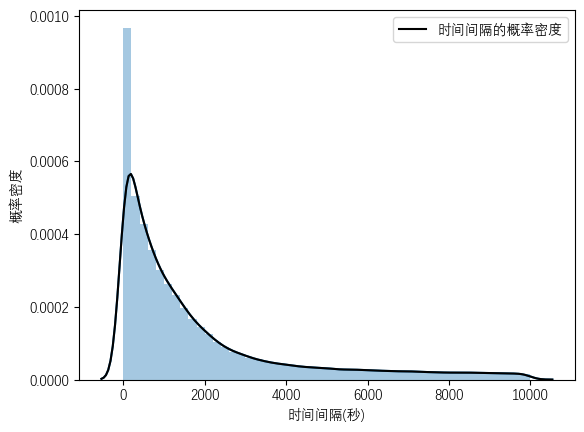

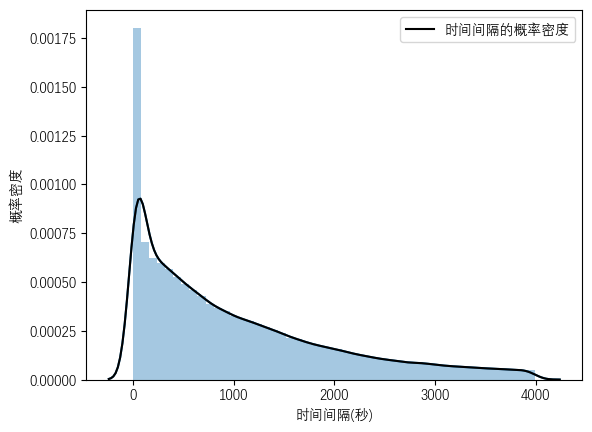

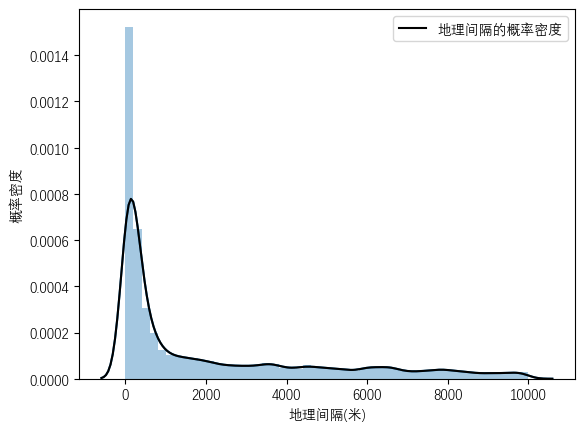

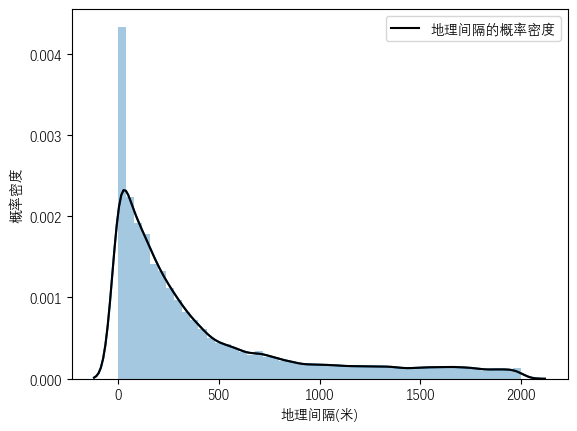

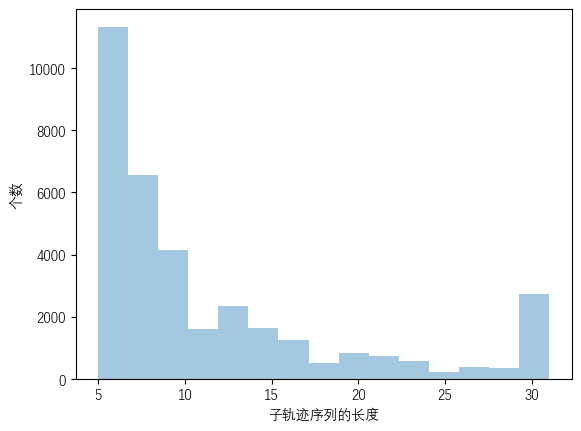

2293
2230


In [38]:
traj_FourSquare = parse_FourSquare("../data/rawData/FourSquare/dataset_TSMC2014_TKY.csv")
statistics(traj_FourSquare, 10000, 4000, 10000, 2000)
filter_FourSquare = split_trajectory_to_sessions(traj_FourSquare, 3600*24, 30, 5, 3)
print(len(traj_FourSquare))
print(len(filter_FourSquare))